In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:99%;}
div.CodeMirror {font-family:Consolas; font-size:20pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

In [ ]:
# 얼굴인식(얼굴정보)-세로*가로*3 넘파이 -> 1*512(임베딩데이터로 변환) -> X, y를 머신러닝(SVM)

# 1. 데이터 셋 다운로드 및 압축해제
https://www.kaggle.com/datasets/dansbecker/5-celebrity-faces-dataset?resource=download

In [ ]:
!unzip data/5celebrity.zip -d data/5celebrity/

# 2. 얼굴 Detect

In [ ]:
# ! pip install mtcnn

In [1]:
from mtcnn import MTCNN
import PIL
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 2.1 MTCNN을 이용해서 얼굴 형태 탐지

In [2]:
detector = MTCNN()
image = cv2.imread('data/5celebrity/train/ben_afflek/httpcsvkmeuaeccjpg.jpg',
                  cv2.IMREAD_ANYCOLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
result

[{'box': [14, 30, 76, 92],
  'confidence': 0.9998857975006104,
  'keypoints': {'nose': [36, 91],
   'mouth_right': [64, 98],
   'right_eye': [51, 63],
   'left_eye': [27, 75],
   'mouth_left': [44, 109]}}]

## 2-2 탐지한 얼굴 그려보기

In [3]:
box = result[0]['box'] # 왼쪽위부분의 x, y, width, height
x, y, w, h = box
keypoints = result[0]['keypoints'] # nose, mouth_right,right_eye, left_eye,mouth_left
cv2.rectangle(image, 
             (x, y), # 사각형 왼쪽윗부분 좌표
             (x+w, y+h), # 사각형 오른쪽 밑부분 좌표
             (0, 155, 255),
              2)
cv2.circle(image, keypoints['nose'], # 원의 중심점
          2, # 반지름
          (255,0,0), #원 색상
          2)
cv2.circle(image, keypoints['mouth_right'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['right_eye'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['left_eye'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['mouth_left'], 2,  (255,0,0), 2)
cv2.imwrite('data/ben.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

face = image[y:y+h, x:x+w]
cv2.imwrite('data/benface.jpg', cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

True

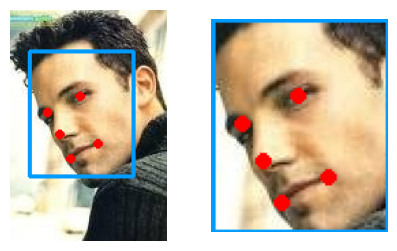

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
axes[0].imshow(image)
axes[0].axis('off')
axes[1].imshow(face)
axes[1].axis('off')
plt.show()

In [ ]:
image = cv2.imread('data/5celebrity/train/elton_john/12.jpg',
                  cv2.IMREAD_ANYCOLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
box = result[0]['box'] # 왼쪽위부분의 x, y, width, height
x, y, w, h = box
keypoints = result[0]['keypoints'] # nose, mouth_right,right_eye, left_eye,mouth_left
cv2.rectangle(image, (x, y), (x+w, y+h), (0, 155, 255),2)
cv2.circle(image, keypoints['nose'], 2, (255,0,0), 2)
cv2.circle(image, keypoints['mouth_right'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['right_eye'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['left_eye'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['mouth_left'], 2,  (255,0,0), 2)
face = image[y:y+h, x:x+w]
fig, axes = plt.subplots(1, 2, figsize=(5,3))
axes[0].imshow(image)
axes[0].axis('off')
axes[1].imshow(face)
axes[1].axis('off')
plt.show()

## 2.3 입력형식에 맞게 차원 변환

In [ ]:
face.shape

In [5]:
face_data = np.expand_dims(face, axis=0)
# face_data = face.reshape(-1, face.shape[0], face.shape[1], face.shape[2]) 비추
face_data = face[np.newaxis, :]
face_data.shape

(1, 92, 76, 3)

# 3. Facenet 활용하여 임베딩 데이터로 변환(face_data를)
- face_data : 1x83x66x3
- 임베딩 데이터 : 1x512

In [ ]:
# ! pip install keras-facenet

In [6]:
from keras_facenet import FaceNet
model = FaceNet()

## 3-1 이미지 데이터를 FaceNet 임베딩 데이터로 변환

In [7]:
# face_data 얼굴 이미지이거나 얼굴 특징 데이터가 있는 이미지를 유사성을 측정할 수 있는 1x512 배열
face_embedding = model.embeddings(face_data)
face_embedding.shape

1/1 [==============================] - 3s 3s/step


(1, 512)

In [ ]:
face_embedding[0, :10]

# 4. 분류모델을 만들기 위해서 데이터셋 생성
- X_train(nx512), y_train(n) * n은 train 폴더안의 사진 갯수
- X_test(mx512) y_test(m)    * m은 test 폴더안의 사진 갯수
## 4.1 y_train(사람이름)과 X_train에 사용될 이미지 경로(x_train_path)
- y_test(사람이름)과 X_test에 사용될 이미지 경로(x_test_path)

In [8]:
import os
train_path = 'data/5celebrity/train'
test_path  = 'data/5celebrity/val'

In [ ]:
for x in os.walk(train_path):
    print(x)
    print('-----------------------------')

In [9]:
def get_path(path):
    x_path = []
    y = []
    for x in os.walk(path):
        if len(x[2])==0:
            # print(x, '에는 파일이 없네요')
            continue
        name = os.path.basename(x[0])
        print(name, '사진', len(x[2]), '장 parsing 중')
        for file_name in x[2]:
            # image_full_path = x[0].replace('\\','/') + '/' + file_name
            image_full_path = path + '/' + name + '/' + file_name
            x_path.append(image_full_path)
            y.append(name)
#     print(len(y))
#     print(len(x_path))
#     for name, path in zip(y, x_path):
#         print(name, path)
    return x_path, y

In [10]:
# get_path(train_path)
x_train_path, y_train = get_path(train_path)
x_test_path, y_test = get_path(test_path)

ben_afflek 사진 14 장 parsing 중
elton_john 사진 16 장 parsing 중
jerry_seinfeld 사진 21 장 parsing 중
madonna 사진 19 장 parsing 중
mindy_kaling 사진 22 장 parsing 중
ben_afflek 사진 5 장 parsing 중
elton_john 사진 5 장 parsing 중
jerry_seinfeld 사진 5 장 parsing 중
madonna 사진 5 장 parsing 중
mindy_kaling 사진 5 장 parsing 중


In [ ]:
len(x_train_path), len(y_train), len(x_test_path), len(y_test)

In [ ]:
for y, x in zip(y_train[::10], x_train_path[::10]):
    print(y, '-', x)

In [ ]:
for y, x in zip(y_test[::10], x_test_path[::10]):
    print(y, '-', x)

## 4-2 임베딩함수를 통해 전체 학습 이미지를 임베딩 처리한 후 train_X리트에 저장

In [11]:
def make_embedding(path):
    'path의 이미지를 읽는다 -> 얼굴정보만 추출 -> facenet을 통해 임베딩 데이터로 전환'
    # print(path)
    image = cv2.imread(path, cv2.IMREAD_ANYCOLOR) # BGR포맷
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB 포맷의 넘파이 배열
    result = detector.detect_faces(image)
    if not result:
        print(path, '의 파일에서는 얼굴을 인지하지 못했습니다')
    #print(result)
    x, y, w, h = result[0]['box']
    # print(x, y, w, h)
    face = image[y:y+h, x:x+w]
    # face 데이터 축 추가
    input_data = np.expand_dims(face, axis=0)
    #print(face.shape, input_data.shape)
    # 임베딩 데이터 전환
    face_embedding = model.embeddings(input_data)
    return face_embedding

In [13]:
X_train_list = []
for image_full_path in x_train_path:
    face_embedding = make_embedding(image_full_path)
    X_train_list.append(face_embedding[0])

1/1 [==============================] - 0s 28ms/step


In [14]:
X_test_list = []

for image_full_path in x_test_path:
    face_embedding = make_embedding(image_full_path)
    X_test_list.append(face_embedding[0])

1/1 [==============================] - 0s 32ms/step


In [15]:
len(X_train_list), len(y_train), len(X_test_list), len(y_test)

(92, 92, 25, 25)

In [16]:
X_train = np.array(X_train_list)
X_test  = np.array(X_test_list)
X_train.shape, X_test.shape

((92, 512), (25, 512))

# 5. SVM(Support Vector Machine) 알고리즘을 이용하여 모델 생성

In [17]:
# svm : 분류분석기, 회귀분석기
from sklearn import preprocessing, svm
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

classifier = svm.SVC(kernel='linear', probability=True) # 확률값 출력
classifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [20]:
y_hat = classifier.predict(X_test) # X_test의 예측값
accuracy = accuracy_score(y_test, # 실제값
                          y_hat)  # 예측값
print(accuracy*100, '%')

100.0 %


In [21]:
confusion_matrix(y_test, y_hat) # 혼돈행렬

array([[5, 0, 0, 0, 0],
       [0, 5, 0, 0, 0],
       [0, 0, 5, 0, 0],
       [0, 0, 0, 5, 0],
       [0, 0, 0, 0, 5]], dtype=int64)

In [22]:
pd.crosstab(y_test, y_hat)

col_0,ben_afflek,elton_john,jerry_seinfeld,madonna,mindy_kaling
row_0,,,,,
ben_afflek,5,0,0,0,0
elton_john,0,5,0,0,0
jerry_seinfeld,0,0,5,0,0
madonna,0,0,0,5,0
mindy_kaling,0,0,0,0,5


# 6. 생성된 모델 사용(예측)하기

In [23]:
image_path = 'data/test_elton.jpg'
face_embedding = make_embedding(image_path)
face_embedding.shape

1/1 [==============================] - 0s 34ms/step


(1, 512)

In [24]:
classifier.predict(face_embedding)

array(['elton_john'], dtype='<U14')

In [26]:
image_path = 'data/test_madonna.jpg'
face_embedding = make_embedding(image_path)
classifier.predict(face_embedding)

1/1 [==============================] - 0s 29ms/step


array(['madonna'], dtype='<U14')

In [27]:
classifier.predict_proba(face_embedding)

array([[0.05548665, 0.04482398, 0.04515228, 0.71462032, 0.13991677]])

# 7. 모델 저장

In [29]:
# SVC 모델은 h5파일로 저장 안됨
import joblib
joblib.dump(classifier, 'model/face_svc.pkl')

['model/face_svc.pkl']

# 8. 모델 불러오기

In [30]:
loaded_model = joblib.load('model/face_svc.pkl')

1/1 [==============================] - 0s 29ms/step
['madonna']
[[0.05548665 0.04482398 0.04515228 0.71462032 0.13991677]]


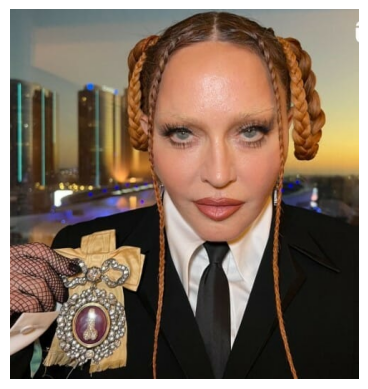

In [33]:
image_path = 'data/test_madonna.jpg'
face_embedding = make_embedding(image_path)
print(loaded_model.predict(face_embedding))
print(loaded_model.predict_proba(face_embedding))
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

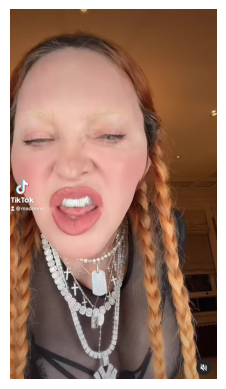

1/1 [==============================] - 0s 30ms/step
[[0.11040307 0.14672894 0.05627796 0.61427231 0.07231771]]
madonna


In [42]:
import requests
image_path = 'https://static.news.zumst.com/images/96/2022/11/09/eea17b5458024856aae080995a499e5a.jpg'
response = requests.get(image_path)
save_path = 'data/test.jpg'
with open(save_path, 'wb') as imageFile:
    imageFile.write(response.content)
image = cv2.imread(save_path, cv2.IMREAD_ANYCOLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()
face_embedding = make_embedding(save_path)
result = loaded_model.predict_proba(face_embedding)
print(result)
names = ['ben_afflek','elton_john','jerry_seinfeld','madonna', 'mindy_kaling']
print(names[result.argmax(axis=1)[0]])